In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
df = pd.read_csv("../data/aggregated_final/infections_testconsumption_dilution.csv")

In [3]:
pooling_methods = ["correlated", "correlated_weak"]

markerdict = { # screening frequency
    "naive": "^",
    "correlated": "o",
    "correlated_weak": "D"   
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}
    
colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

for pooling_method in pooling_methods:

    for row_idx, row in df.iterrows():
        result_single = [
            row["num_groups"], row["pool_size"],
            row[f"cum_num_tests_{pooling_method}_mean"], row[f"cum_num_tests_{pooling_method}_sem"],
            row[f"cumInfections_{pooling_method}_mean"], row[f"cumInfections_{pooling_method}_sem"]
        ]
        all_results[pooling_method].append(result_single)

    all_results[pooling_method].sort(key=lambda x: x[4])

    pareto_results[pooling_method] = [all_results[pooling_method][0]]
    for i in range(1, len(all_results[pooling_method])):
        if all_results[pooling_method][i][2] < pareto_results[pooling_method][-1][2]:
            pareto_results[pooling_method].append(all_results[pooling_method][i])
    

In [5]:
critical_test_consumptions = [l[2] for l in pareto_results["correlated_weak"]] + [l[2] for l in pareto_results["correlated"]]
critical_test_consumptions.sort(reverse=True)

ccp = pareto_results["correlated_weak"]
ccp.sort(key=lambda x: x[2], reverse=True)

hcp = pareto_results["correlated"]
hcp.sort(key=lambda x: x[2], reverse=True)

In [6]:
# loop over corr_dilution
# find entry in corr_no_dilution with closest and smaller test consumption

# for each point in corr_dilution, find the closest point in corr_no_dilution
# if the closest point in corr_no_dilution has smaller test consumption, then compare the outcomes

from collections import defaultdict
scenarios = defaultdict(int)
regret = []
feasible = []
test_overuse = []

policies = []

true_idx = 0
model_idx = 0

for i, critical_test_consumption in enumerate(critical_test_consumptions):

    while true_idx < len(ccp) and ccp[true_idx][2] > critical_test_consumption:
        true_idx += 1
    if true_idx == len(ccp):
        print(critical_test_consumption, "true idx reached end")
        break

    while model_idx < len(hcp) and hcp[model_idx][2] > critical_test_consumption:
        model_idx += 1
    if model_idx == len(hcp):
        print(critical_test_consumption, "model idx reached end")
        break

    # corr-enhancing optimal policy
    num_groups, pool_size, num_tests, num_tests_sem, cum_infections, cum_infections_sem = hcp[model_idx]

    # comm corr (do-nothing) optimal policy
    num_groups_, pool_size_, num_tests_, num_tests_sem_, cum_infections_, cum_infections_sem_ = ccp[true_idx]
    
    policies.append((i, (int(num_groups_), int(pool_size_)), (int(num_groups), int(pool_size))))
    regret.append(cum_infections_ - cum_infections)



34483.05025125628 true idx reached end


## Figure 8

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will r

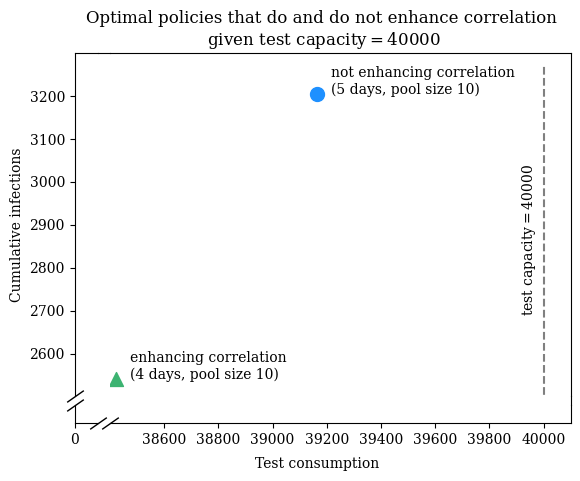

In [7]:
# use broken axis
# https://stackoverflow.com/questions/70700017/broken-y-axis-from-0-to-value-start-with-matplotlib-and-pandas-data 

plt.rcParams["font.family"] = 'serif'


plt.rcParams["font.family"] = 'serif'
fig, axes = plt.subplots(2, 2,
                            sharex='col', sharey='row',                               
                            gridspec_kw={
                                   'height_ratios': [1, 0.05],
                                   'width_ratios': [0.05, 1]
                               })
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.05, wspace=0.05)

ax1.set_ylim(2500, 3300) 
ax3.set_ylim(0,100)
ax4.set_xlim(38400, 40100)
ax4.set_ylim(0,100)
ax1.set_xlim(0,100)


test_capacity = 40000

policy_idx = 0
while critical_test_consumptions[policy_idx] > test_capacity:
    policy_idx += 1     

# bad naming; true-optimal = corr-aware; model-optimal = corr-enhancing
capacity_idx, true_optimal_policy, model_optimal_policy = policies[policy_idx]

modeled_outcome = df[
    (df["num_groups"] == model_optimal_policy[0])
    & (df["pool_size"] == model_optimal_policy[1])
]

optimal_outcome = df[
    (df["num_groups"] == true_optimal_policy[0])
    & (df["pool_size"] == true_optimal_policy[1])
]

ax2.scatter(
    optimal_outcome["cum_num_tests_correlated_weak_mean"],
    optimal_outcome["cumInfections_correlated_weak_mean"],
    color="dodgerblue",
    marker="o",
    s=100
)
ax2.annotate(
    f"not enhancing correlation\n({true_optimal_policy[0]} days, pool size {true_optimal_policy[1]})",
    (optimal_outcome["cum_num_tests_correlated_weak_mean"]+50, optimal_outcome["cumInfections_correlated_weak_mean"]),
)

ax2.scatter(
    modeled_outcome["cum_num_tests_correlated_mean"],
    modeled_outcome["cumInfections_correlated_mean"],
    color="mediumseagreen",
    marker="^",
    s=100
)
ax2.annotate(
    f"enhancing correlation\n({model_optimal_policy[0]} days, pool size {model_optimal_policy[1]})",
    (modeled_outcome["cum_num_tests_correlated_mean"]+50, modeled_outcome["cumInfections_correlated_mean"]),
)

plt.suptitle(
    f"Optimal policies that do and do not enhance correlation\n given test capacity$=${test_capacity}",
    x=0.51, y=0.97
)

ax2.vlines(
    x = test_capacity,
    ymin = 2400,
    ymax = 3275,
    color="grey", linestyle="--")
ax2.annotate(
    f"test capacity$=${test_capacity}",
    (test_capacity-20, 2700),
    ha='right',
    rotation=90
)

ax4.set_xlabel("Test consumption")
ax4.xaxis.set_label_coords(0.45, -2)
ax1.set_ylabel("Cumulative infections")

ax1.spines['bottom'].set_visible(False) 
ax1.spines['right'].set_visible(False) 

ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False) 

ax4.spines['left'].set_visible(False) 
ax4.spines['top'].set_visible(False) 


ax1.xaxis.set_ticks_position('none') 
ax2.xaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 
ax3.yaxis.set_ticks_position('none') 
ax4.yaxis.set_ticks_position('none') 


ax1.set_yticks(ax1.get_yticks()[1:-1])
ax3.set_yticks([])
ax3.set_xticks(ax3.get_xticks()[:-1])
ax4.set_xticks(ax4.get_xticks()[1:-1])



d = 0.7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,  # "length" of cut-line
    linestyle='none',
    color='k',  # ?
    mec='k',  # ?
    mew=1,  # line thickness
    clip_on=False
)
ax1.plot([0],[0], transform=ax1.transAxes, **kwargs)
ax3.plot([0], [1], transform=ax3.transAxes, **kwargs)
ax3.plot([1], [0], transform=ax3.transAxes, **kwargs)
ax4.plot([0], [0], transform=ax4.transAxes, **kwargs)

vertical_patch = plt.Line2D(
    (ax2.get_position().xmax, ax2.get_position().xmax),
    (ax4.get_position().ymax, ax2.get_position().ymin), 
    color="k", linewidth=ax1.spines["top"]._linewidth)
fig.add_artist(vertical_patch)

horizontal_patch = plt.Line2D(
    (ax1.get_position().xmax, ax2.get_position().xmin),
    (ax1.get_position().ymax, ax1.get_position().ymax), 
    color="k", linewidth=ax1.spines["top"]._linewidth)
fig.add_artist(horizontal_patch)
